EE675A: Assignment 3 

Part 1: SARSA  (Deadline: 26th March 2023)

Part 2: Q-Learning  (Deadline: 30th March 2023)




# Cliff Walking 

Through this gridworld exercise we will compare Sarsa and Q-learning algorithms, highlighting the difference between them. Consider the gridworld shown in the Figure below. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is −1 on all transitions except those into the the region marked “The Cliff.” Stepping into this region incurs a reward of −100 and sends the agent instantly back to the start.

There are totally 48 states numbered from 0 to 47

<img src='cliff_walking.png' width="600" align="left"></img> 



In [1]:
pip install gym==0.21.0


Note: you may need to restart the kernel to use updated packages.


In [5]:
gym.__version__

'0.21.0'

In [7]:
# Imports
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt
from collections import defaultdict
matplotlib.style.use('ggplot')

# The environment class is already created for you. You have to just import it as follows.
from cliff_walking import CliffWalkingEnv
#env=gym.make('CliffWalking-v0')


ModuleNotFoundError: No module named 'cliff_walking'

In [8]:
# Create environment
env = CliffWalkingEnv()

env.render()  
# Render is to see where we are in the environment
# "x" represents our current position in the grid
# "C" represents a cliff cell
# "T" is the target (Goal) cell
# "o" all the other cells


NameError: name 'CliffWalkingEnv' is not defined

In [9]:
l = env.reset()
#env.step(0)

NameError: name 'env' is not defined

In [41]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [42]:
env.step(2)

(36, -1, False, {'prob': 1.0})

In [43]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [44]:
# Allowed Actions
# 0 => UP
# 1 => Right
# 2 => Down
# 3 => Left


# Let us take a few actions and get familiar with the environment
print('We started here')
env.reset()
env.render()

# Let us take up first
print('Let us take UP action')
env.step(0)
env.render()

# Now lets take another UP
print('Another UP action')
env.step(0)
env.render()

# Now lets take two rights
print('Two Right actions')
env.step(1)
env.step(1)
env.render()

# Now one left
print('One Left action')
env.step(3)
env.render()

We started here
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Let us take UP action
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Another UP action
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Two Right actions
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

One Left action
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [45]:
# A helper function for plotting the comparision graphs between two or more algorithms. 
# You need not understand this code.
# Just look at the next cell to understand how to use it.


def plot_episode_reward(a, stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    for stat in stats:
        rewards_smoothed = pd.Series(stat).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.legend(a)
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

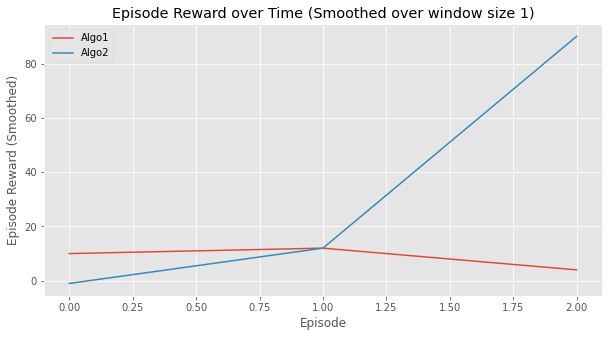

In [46]:
#Demo for using Plotting helper function
#Here we are comparing two algorithms which were run for 3 episodes each. 

stats_algo1= [10,12,4]    #The return obtained in each episode for Algo1
stats_algo2= [-1,12,90]    #The return obtained in each episode for Algo2

#Plotting the comparision
#Here the last argument is to smoothen the plot. Use higher values such as 10 for smooth plots.

plot_episode_reward(['Algo1','Algo2'],[stats_algo1,stats_algo2],smoothing_window=1)  

### Epsilon-greedy policy from Q-function and epsilon

Helper function to create epsilon-greedy policy based on a given Q-function and epsilon.

In [47]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the state/observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [48]:
# How to use make_epsilon-greedy_policy function
# consider two states s1, s2 and 3 actions {0,1,2} in each state

Q={1:[0.5, 2, 3], 2:[-0.1, 4 , 3]}  # A sample Q-function Q(s,a) for each state-action pair

# For this example it is clear that for state s1, action 2 is the greedy action.
# For state s2, action 1 is the greedy action

"""
If we want an epsilon greedy policy with epsilon=0.3, then the best action
should get a probility = 0.7 + 0.3/3 = 0.8
other action with probability = 0.3/3 = 0.1

"""

# Let us verify this using our make_epsilon-greedy_policy function

policy_fn = make_epsilon_greedy_policy(Q, epsilon=0.3, nA=3)

print("The epsilon-greedy policy at state s1 is ", policy_fn(1))
print("The epsilon-greedy policy at state s2 is ", policy_fn(2))
print(np.argmax(policy_fn(2)))


The epsilon-greedy policy at state s1 is  [0.1 0.1 0.8]
The epsilon-greedy policy at state s2 is  [0.1 0.8 0.1]
1


## 1. SARSA algorithm

Implement the SARSA update to find the optimal action value function **[10 Marks]**

In [49]:
import sys
import random
import numpy as np
def weighted_choice(v, p):
   total = sum(p)
   r = random.uniform(0, total)
   upto = 0
   for c, w in zip(v,p):
      if upto + w >= r:
         return c
      upto += w
   assert False, "Shouldn't get here"

In [50]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a numpy array that stores the returns obtained in each episode
        For example, if we have run for 2 episodes and the returns obtained are -10, -25,
        stats=[-10,-25]

    """
    
    #Write your code here...#
    #Write your code here...#
    a = list(np.arange(0,48))
    Q = {a[i]: [0,0,0,0] for i in range(len(a))}
    states = list(Q.keys())
    Actions = [0,1,2,3]
    stats = np.zeros(episodes)
    for j in range(episodes):
        i = env.reset()
        k = make_epsilon_greedy_policy(Q, epsilon, nA=4)
        A = weighted_choice(Actions,k(i))
        is_terminal = False
        while not is_terminal:
            next_state,reward,is_terminal,_ = env.step(A)
            A_nxt = weighted_choice(Actions,k(next_state))
            Q[i][A] = Q[i][A] + alpha*(reward + discount_factor*(Q[next_state][A_nxt])-Q[i][A])
            i = next_state
            A = A_nxt
            stats[j]+=reward
    pi = np.zeros(48)-1
    Q_f = dict.fromkeys(a,0)
    for s in states:
        m = max(Q[s])
        Q_f[s] = m
        pi[s] = Q[s].index(m)
    pi[47] = None
    pi = pi.reshape([4,12])
    print("\n--------------SARSA algorithm---------------\n")
    print("\nOptimal policy is\n 0->UP,1->RIGHT,2->DOWN,3->LEFT,-1->CLIFF")
    print(pi)
    print("\nOptimal Action value function is")
    print(Q_f)
    return Q_f, stats


--------------SARSA algorithm---------------


Optimal policy is
 0->UP,1->RIGHT,2->DOWN,3->LEFT,-1->CLIFF
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
 [ 0.  0.  0.  3.  2.  3.  0.  1.  1.  0.  1.  2.]
 [ 0.  0.  1.  3.  1.  0.  0.  0.  0.  0.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan]]

Optimal Action value function is
{0: -14.863432737723002, 1: -13.806555046650132, 2: -13.514536102888137, 3: -12.20757408987362, 4: -11.334132849480056, 5: -9.970441506855831, 6: -9.451504447224334, 7: -7.669969602685829, 8: -6.520581845306053, 9: -5.383957018865891, 10: -4.278259101609565, 11: -3.134624151361749, 12: -16.15969722088664, 13: -15.47083746916176, 14: -14.129170166153983, 15: -12.836439472552795, 16: -12.216104969074154, 17: -10.23482836762446, 18: -9.744258697338665, 19: -8.60573601535464, 20: -6.405524602279076, 21: -6.585379110072675, 22: -3.4919046951736714, 23: -2.027372467069256, 24: -18.212779904994548, 25: -16.533762408654045, 26: -12.12940854876695, 27: -

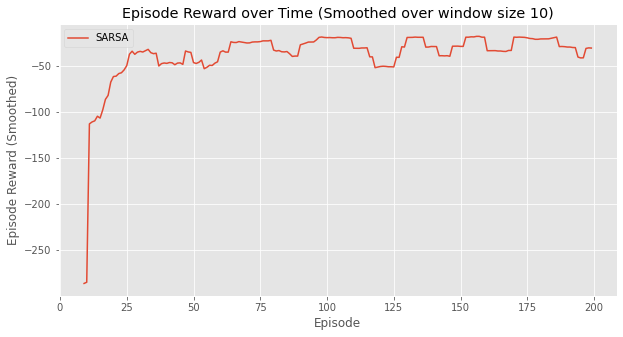

In [51]:
episodes = 200
Q_sarsa, stats_sarsa = sarsa(env, episodes, epsilon=0.1)

plot_episode_reward(['SARSA'],[stats_sarsa])

## 2. Q-Learning algorithm

Implement the Q-Learning update to find the optimal action value function **[10 Marks]**

In [52]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a numpy array that stores the return obtained in each episode
    """
    
    #Write your code here...#
    #Write your code here...#
    a = list(np.arange(0,48))
    #a.append(47)
    Q = {a[i]: [0,0,0,0] for i in range(len(a))}
    states = list(Q.keys())
    Actions = [0,1,2,3]
    stats = np.zeros(episodes)
    step = np.zeros(episodes)
    for j in range(episodes):
        i = env.reset()
        k = make_epsilon_greedy_policy(Q, epsilon, nA=4)
        is_terminal = False
        while not is_terminal:
            step[j] = step[j]+1
            A = weighted_choice(Actions,k(i))
            next_state,reward,is_terminal,_ = env.step(A)
            all_nxtS=[]
            for act in Actions:
                all_nxtS.append(Q[next_state][act])
                maxQ = max(all_nxtS)
            Q[i][A] = Q[i][A] + alpha*(reward + discount_factor*(maxQ)-Q[i][A])
            i = next_state
            stats[j]+=reward
    pi = np.zeros(48)-1
    Q_f = dict.fromkeys(a,0)
    for s in states:
        m = max(Q[s])
        Q_f[s] = m
        pi[s] = Q[s].index(m)
    pi[47] = None
    pi = pi.reshape([4,12])
    print("\n--------------QLearning algorithm---------------\n")
    print("\nOptimal policy is\n 0->UP,1->RIGHT,2->DOWN,3->LEFT,-1->CLIFF")
    print(pi)
    print("\nOptimal Action value function is")
    print(Q_f)
    print("episode_lengths",step)
    return Q_f, stats, step

### Running and Generating Plots


--------------QLearning algorithm---------------


Optimal policy is
 0->UP,1->RIGHT,2->DOWN,3->LEFT,-1->CLIFF
[[ 1.  1.  0.  1.  3.  0.  1.  1.  1.  1.  3.  2.]
 [ 3.  2.  1.  1.  2.  1.  1.  2.  1.  2.  1.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan]]

Optimal Action value function is
{0: -11.711191117166237, 1: -11.16896865755217, 2: -10.408158922567964, 3: -9.699748889994225, 4: -8.945609629154205, 5: -8.061355590820312, 6: -7.245205119252205, 7: -6.424409069499234, 8: -5.548154211603105, 9: -4.758477164197856, 10: -3.8798828125, 11: -2.983365586487614, 12: -11.951247304677963, 13: -11.542152818482295, 14: -10.740742922205559, 15: -9.845860690369149, 16: -8.914211313517054, 17: -7.944961677686814, 18: -6.97706718323194, 19: -5.994841842822469, 20: -4.998675855990391, 21: -3.9995158693842465, 22: -2.9999229357752757, 23: -1.9999999044948673, 24: -12.0, 25: -11.0, 26: -10.0, 27: -9.0, 28: -8.0, 29: -7.0, 30: -6.0, 31: -5.

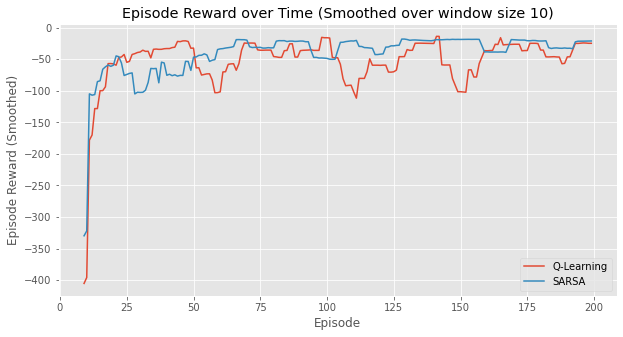

In [53]:
episodes = 200
Q_q, stats_q, rollout_stats_q = q_learning(env, episodes, epsilon=0.1)
Q_sarsa, stats_sarsa = sarsa(env, episodes, epsilon=0.1)
plot_episode_reward(['Q-Learning','SARSA'],[stats_q, stats_sarsa])

### Visualizing the policy

In [54]:
# extracting greedy policy from the Q function
pi_sarsa = np.zeros(env.observation_space.n)
print(pi_sarsa)
pi_q = np.zeros(env.observation_space.n)
for s in range(env.observation_space.n):
    pi_sarsa[s] = np.argmax(Q_sarsa[s])
    pi_q[s] = np.argmax(Q_q[s])
    
pi_sarsa = np.reshape(pi_sarsa, env.shape)
pi_q = np.reshape(pi_q, env.shape)
# print(pi_sarsa)

print('SARSA policy:')
env.render_policy(pi_sarsa)
print('Q-learning policy:')
env.render_policy(pi_q)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SARSA policy:


AttributeError: 'CliffWalkingEnv' object has no attribute 'render_policy'

In [55]:
env.observation_space.n

48